# Evaluación de afirmaciones en programas de gobierno 2025

El objetivo de este experimento es consultar a un modelo LLM, qué planes de gobierno están mejor o peor alineados con un conjunto de [afirmaciones](https://github.com/strymsg/programas-de-gobierno-2025/blob/main/afirmaciones1_rg.md) dadas, indicando la razón del verdicto y citando las secciones de los planes de gobierno que lo respalden.

Para este experimento se usa [RAG](https://en.wikipedia.org/wiki/Retrieval-augmented_generation) usando los [programas de gobierno transcritos a markdown por mauforonda](https://github.com/mauforonda/programas-de-gobierno-2025) como documentos. Hay dos implmentaciones ambas con `chromaDB` como base de datos vectorial.

- ollama con modelo LLM `deepseek-r1:latest` (implementación 1). 
- modelo LLM `deepseek-reasoner` consultado por API (implemntación 2) [resultados completos](./data/)

LICENCIA: GPLv3 - Rodrigo Garcia (rgarcia@laotra.red) Agosto 2025.

## ¿Cómo funciona este experimento?

Lo primero que se hace es dividir cada plan de gobierno en pedazos (*chunks*) para luego introducirlos en la BD vectorial, a cada uno se lo etiqueta con el nombre del plan de gobierno y la sección a la que pertenecen. Luego se cargan cada una de las afirmaciones y se obtienen los *chunks* que más se parezcan a cada afirmación consultando la BD vectorial con una estrategia por defecto (esta estrategia se podría cambiar).

Finalmente con los *chunks* que más se parezcan a la afirmación, se crea un *prompt* para que el modelo LLM de razonamiento los evalúe y determine cúales son los mejores y peores alineados a cada afirmación. Los resultados se guardan como archivos json.

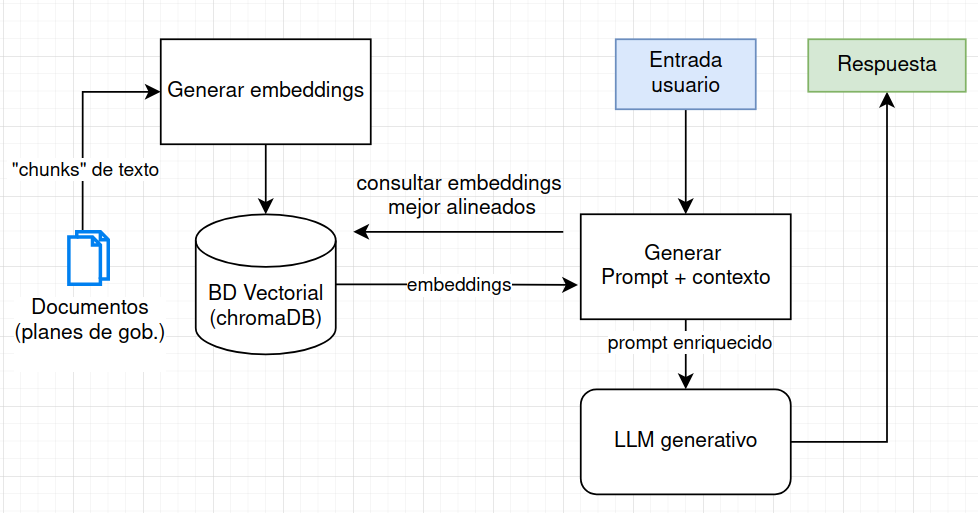

In [ ]:
# Algunos requerimientos
!pip install ollama
!pip install chromadb
!pip install langchain
!pip install langchain_community
!pip install langchain-text-splitters
!pip install openai

In [4]:
####################### SOME UTILS #######################
##########################################################

##### SOME utils to read markdown files
###################################################
from langchain_text_splitters import MarkdownHeaderTextSplitter, ExperimentalMarkdownSyntaxTextSplitter
import os
import re

def list_markdown_files(directory: str):
    """Returns the list of all markdown files in a given directory"""
    files = []
    for filename in os.listdir(directory):
        if filename.endswith(".md"):
            files.append(filename)
    return files


def load_markdown_files(directory: str) -> str:
    """Combine all .md files in directory into a single string"""
    combined = ""
    for filename in os.listdir(directory):
        if filename.endswith(".md"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                # Remove special characters to reduce token noise
                cleaned = re.sub(r'[^\w\s.,;:!?()\-]', '', f.read())
                combined += f"--- {filename} ---\n{cleaned}\n\n"
    return combined


def get_markdown_file(directory: str, filename: str, clean=False) -> dict:
    """Given a directory and filename, returns its name and content"""
    filedict = {}

    with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
        # Remove special characters to reduce token noise
        if clean:
            cleaned = re.sub(r'[^\w\s.,;:!?()\-]', '', f.read())
            filedict['content'] = cleaned
        else:
            filedict['content'] = f.read()
        filedict['name'] = filename
    return filedict


def get_markdown_sections(content: str):
    """Gets the markdown content as documents splited by their headers"""
    headers_to_split_on = [
        ("#", "H1"),
        ("##", "H2"),
        ("###", "H3"),
        ("####", "H4"),
        ("#####", "H5"),
        ("######", "H6"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    documents = markdown_splitter.split_text(content)
    #print('==========================')
    #print(documents)
    return documents


In [5]:
##### Utils to handle chunks and store in chroma_db #####
#########################################################
def get_complete_header_for_section(doc_section, divider=' ▸ '):
    """From a document section of langchain MarkdownHeaderTextSplitter,
    returns all headers  in metadata concatenated with the `divider'.
    E.g. H1: Title, H2: subtitle, H3: level3, H4: level4 --> Title ▸ Subtitle ▸ level3 ▸ level4
    """
    header_section = ''
    for header, header_text in doc_section.metadata.items():
        header_section += header_text + divider
    return header_section[:-len(divider)]

In [23]:
def get_chunks_for_doc_sections(doc_sections, max_chunk_size=815):
    """Given a list of document sections from Langchain MarkdownHeaderTexSplitter
    return chunks based on their header sections and a max chunk size. Every chunk
    has the format:
    [
      {
        "section": "(section_name)((subsection_number_if_exists))",
        "content": "section_content",
      }
    ]
    """
    chunks = []
    for section in doc_sections:
        section_name = get_complete_header_for_section(section)

        sub_sections = []
        if len(section.page_content) > max_chunk_size:
            # spliting in sections
            for i in range(0, len(section.page_content), max_chunk_size):
                # TODO: Avoid break words or even sentences.
                sub_sections.append(section.page_content[i: i+max_chunk_size])
            for j, sub_section in enumerate(sub_sections):
                chunk = {}
                chunk['section'] = get_complete_header_for_section(section) + f'({j})'
                chunk['content'] = sub_section
                chunks.append(chunk)
        else:
            chunks.append({
              'section': section_name,
              'content': section.page_content
            })
        print(f'{section_name}, splits {len(sub_sections)}. Size({len(section.page_content)})')
    return chunks

In [39]:
import hashlib

def add_chunks_to_chromadb(chunks, plan_name):
    """Adds the chunks list to chroma db. for every chunk uses the given plan_name"""
    ids = [
        # Apply a hash function to ensure uniqueness
        hashlib.md5(f"{plan_name}_{chunk['section']}".encode()).hexdigest()[:5]
        for chunk in chunks
    ]
    collection.add(
        ids=ids,
        documents=[chunk['content'] for chunk in chunks],
        metadatas=[{ "plan": plan_name, "section": chunk['section']} for chunk in chunks]
    )
    print(f"total of {len(chunks)} chunks added.")

In [40]:
# testing a government plan
government_plan = get_markdown_file('../programas', 'morena.md')
doc_sections = get_markdown_sections(government_plan['content'])
get_chunks_for_doc_sections(doc_sections)

, splits 0. Size(236)
CONTEXTO ACTUAL, splits 5. Size(3507)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO, splits 2. Size(1015)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 1. Reducción responsable del tamaño del aparato estatal, splits 0. Size(661)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 2. Política de austeridad y reducción de salarios jerárquicos, splits 0. Size(745)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 3. Digitalización integral del Estado, splits 0. Size(694)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 4. Simplificación administrativa, splits 0. Size(644)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 5. Institucionalización del servicio público, splits 0. Size(694)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 6. Creación del Instituto Plurinacional de Ética Pública, splits 0. Size(488)
EJE 1 - INSTITUCIONALIDAD DEMOCRÁTICA DEL ESTADO ▸ 7. Mecanismos vinculantes de control social y rendición de cuentas, splits 0. Size(567)
EJE 2. 

[{'section': '',
  'content': '---\ntitle: MORENA\ndescription: Eva Copa\nimage: /src/images/morena.webp\ntitle-block-banner: true\ncode-links:\n- text: Markdown\nicon: markdown\nhref: https://github.com/mauforonda/programas-de-gobierno-2025/blob/main/programas/morena.md\n---'},
 {'section': 'CONTEXTO ACTUAL(0)',
  'content': 'Bolivia atraviesa uno de los momentos más complejos y desafiantes desde la recuperación de la democracia. La combinación de crisis estructurales, el desgaste del sistema político y el debilitamiento del tejido social ha derivado en un profundo sentimiento de estancamiento, frustración y falta de horizonte colectivo.  \nEn primer lugar, se evidencia una pérdida de la institucionalidad democrática, las instituciones públicas han sido capturadas por intereses particulares, debilitadas por la corrupción o reducidas a instrumentos de disputa entre facciones políticas. La justicia ha dejado de ser un poder independiente y ha pasado a ser utilizada como mecanismo de per

In [41]:
# instantiating chroma db
import chromadb
chroma_client = chromadb.PersistentClient(path="../data/prog_gobierno")

collection_name = "programas_gobierno"

if len(chroma_client.list_collections()) > 0 and collection_name in [chroma_client.list_collections()[0].name]:
    chroma_client.delete_collection(name=collection_name)

collection = chroma_client.create_collection(name=collection_name)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [42]:
def obtain_from_chroma_to_send_to_prompt(query_texts: str, plans, nresults=5):
    """Gets results from querying the given text from chromaDB collection applying 
    a filter for the given government plan list. Returns a list of dictionaries
    with results.

    Parameters:
    query_texts (str): Text to search in the database
    plans (list[str]): String list of government plan names to search in.
    nresults (int): Number of results to get from the DB.

    Returns:
    (list[str]): List of dictionaries with format:
    [{ 
       'plan': (government_plan_name), 
      'section': (section where the match was found in the plan),
      'content': (content found)
    }, ...]
    """
    results = collection.query(
        query_texts=query_texts,
        where = {
            "$or": [{ 'plan': plan } for plan in plans]
        },
        n_results=nresults
    )
    results_to_return = []
    for i, _result_tuple in enumerate(results['distances']):
        for j in range(0, len(_result_tuple)):
            results_to_return.append({
                'plan': results['metadatas'][i][j]['plan'],
                'section': results['metadatas'][i][j]['section'],
                'content': results['documents'][i][j]
            })
    return results_to_return

In [43]:
############### Inserting all plans to chromaDB #############
PLANS_DIR='../programas'

archivos_programas_de_gobierno = list_markdown_files(PLANS_DIR)

# Chunking and storing every plan in chroma db
for i, prog_gobierno in enumerate(archivos_programas_de_gobierno):
    print(f"______Procesando y recolectando embedings de {i}: {prog_gobierno}__________\n")
    government_plan = get_markdown_file(PLANS_DIR, prog_gobierno)
    doc_sections = get_markdown_sections(government_plan['content'])
    chunks = get_chunks_for_doc_sections(doc_sections, max_chunk_size=860)
    add_chunks_to_chromadb(chunks, government_plan['name'])

______Procesando y recolectando embedings de 0: partido-democrata-cristiano.md__________

, splits 0. Size(362)
A. EL ESTADO "TRANCA", splits 2. Size(976)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL ▸ B.1. Situación problemática, splits 2. Size(1082)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL ▸ B.1. Situación problemática ▸ 1) Crisis económica: estanflación y desequilibrios estructurales ▸ Estancamiento con inflación, splits 0. Size(445)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL ▸ B.1. Situación problemática ▸ 1) Crisis económica: estanflación y desequilibrios estructurales ▸ Crisis de divisas, splits 0. Size(266)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL ▸ B.1. Situación problemática ▸ 1) Crisis económica: estanflación y desequilibrios estructurales ▸ Dependencia de los "commodities", splits 0. Size(470)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL ▸ B.1. Situación problemática ▸ 1) Crisis económica: estanflación y desequilibrios estructurales ▸ Déficit fiscal crítico, splits 3. Size(1767)
B. ANÁLISIS DE LA SITUACIÓN ACTUAL 

Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


total of 79 chunks added.
______Procesando y recolectando embedings de 1: mas-ipsp.md__________

, splits 0. Size(254)
DE BOLIVIA, POR BOLIVIA, PARA BOLIVIA. MARCO GENERAL DEL PROGRAMA, splits 5. Size(3956)
II DESARROLLO ECONÓMICO PARA LA DIVERSIFICACIÓN PRODUCTIVA ▸ 1. ESTADO DE SITUACIÓN ▸ RECONDUCIR EL PROCESO PARA ACELERAR LA INDUSTRIALIZACIÓN, splits 2. Size(1454)
II DESARROLLO ECONÓMICO PARA LA DIVERSIFICACIÓN PRODUCTIVA ▸ 2. LOS EJES PROGRAMÁTICOS, PROPUESTAS Y ACCIONES: ▸ a) CONTROL Y REDIRECCIONAMIENTO DE EXCEDENTES EN SECTORES DE GANACIAS EXTRAORDINARIAS ▸ Minería, splits 0. Size(404)
II DESARROLLO ECONÓMICO PARA LA DIVERSIFICACIÓN PRODUCTIVA ▸ 2. LOS EJES PROGRAMÁTICOS, PROPUESTAS Y ACCIONES: ▸ a) CONTROL Y REDIRECCIONAMIENTO DE EXCEDENTES EN SECTORES DE GANACIAS EXTRAORDINARIAS ▸ Agroindustria, splits 0. Size(299)
II DESARROLLO ECONÓMICO PARA LA DIVERSIFICACIÓN PRODUCTIVA ▸ 2. LOS EJES PROGRAMÁTICOS, PROPUESTAS Y ACCIONES: ▸ a) CONTROL Y REDIRECCIONAMIENTO DE EXCEDENTES EN 

Add of existing embedding ID: 29409
Insert of existing embedding ID: 29409


total of 218 chunks added.
______Procesando y recolectando embedings de 7: libertad-y-progreso-adn.md__________

, splits 7. Size(5246)
A. CRITERIOS DE DECISION, splits 2. Size(1173)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 1: Reforzar profundamente la propiedad privada y asegurar plenos derechos de propiedad privada sobre los medios de producción., splits 3. Size(1800)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 2: Abandonar la economía estatista, splits 2. Size(1498)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 3: Reformar la CPE y las reglas de juego político, splits 2. Size(1442)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 4: Reformar el Estado, splits 3. Size(2230)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 5: Reformar la Justicia, splits 2. Size(1316)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 6: Reformas en los sistemas de salud y educación, splits 0. Size(691)
B. DIEZ IDEAS-FUERZA ▸ Idea-Fuerza 7: Desarrollar una amplia y efectiva batalla cultural para reafirmar los valores y principios de la civilización occidental, splits 3.

In [44]:
### Testing querying embeddings
from pprint import pprint

# buscando solo en morena, libertad-y-progreso.md u alianza unidad
results = collection.query(
    query_texts=["Agroforestal", "Conservación", "Se garantiza la inversión en energías renovables"],
    where=
      {
          "$or": [
              {"plan": "morena.md"},
              {"plan": "alianza-libertad-y-democracia.md"},
              {"plan": "alianza-unidad.md"}
          ]
      },
    n_results=5)

pprint(results)
print(results.keys())

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


{'data': None,
 'distances': [[1.1313776969909668,
                1.2161496877670288,
                1.2476972341537476,
                1.260085940361023,
                1.2695942407497574],
               [1.2110459804534912,
                1.2352073192596436,
                1.286350131034851,
                1.3304274082183838,
                1.346720814704895],
               [0.8120297193527222,
                0.9706858992576599,
                0.9729406833648682,
                0.9763164520263672,
                0.9836474657058716]],
 'documents': [[' generación de granjas piscícolas, con asistencia técnica y '
                'crédito en todo el país. Fortaleceremos e '
                'institucionalizaremos la infraestructura construida y '
                'subutilizada para la producción de productos derivados de '
                'camélidos.\n'
                '10. Implementaremos clústeres agroalimentarios de alta '
                'productividad. Desarrollaremos s

In [48]:
import ollama
import json
import os

###################################################################
################ Utils to send prompt to the LLM ##################
def prompt_to_compare_statements(statement_name, statement, sections_obtained):
    sections_formated = ""
    for section in sections_obtained:
        sections_formated += f"""{section['plan']}:{section['section']}
        {section['content']}
        --
        """
    
    prompt = f"""
You will be given sections of government plans in format and in spanish language:
(government_plan_name):(section_in_government_plan)
(section_content)
--
Here the sections:
    
{sections_formated}
    
Tell me which (government_plan_name) is better and worse aligned with
the following statement with name "{statement_name}" and content:
{statement}

Answer following these format
- Output must be in SPANISH languange only
- Output JSON format with structure:
{{
  "afirmación": "(statement_name)\n(statement_content)",
  "comparaciones": {{
       "mejor_alineado": {{
          "plan": (government_plan_name),
          "razón": (reason you think it supports the statement),
          "puntaje": (score from 0 to 10),
          "evidencia_clave": {{
              "sección": (section_in_government_plan), "texto_citado": (section_content),
              "relevancia": (reason you think this section supports the statement)
          }}
        }},
        "peor_alineado": {{
          "plan": (government_plan_name),
          "razón": (reason you think it contradicts or worse supports the statement),
          "puntaje": (score from 0 to 10),
          "evidencia_clave": {{
              "sección": (section_in_government_plan), "texto_citado": (section_content),
              "relevancia": (reason you think this section contradicts or worse supports the statement)
          }}
        }}
  }}
}}
    """
    return prompt


## Implementación 1 - ollama con modelo LLM `deepseek-r1:latest`

Se requiere tener [ollama](https://ollama.com/) instalado en el sistema y también el modelo `deepseek-r1:latest` descargado `ollama pull deepseek-r1:latest`. Se puede probar otro modelo.

In [14]:

def get_ollama_llm_response(prompt, reasoning_model, temperature=0.14):
    print(f"Getting response from model {reasoning_model}. Prompt lenght: {len(prompt)}")
    response = ollama.generate(
        model=REASONING_MODEL,
        prompt=prompt,
        options={"temperature": temperature}
    )
    print(f">>> {reasoning_model} RAW RESPONSE:\n{response}")
    return response['response']


In [ ]:
#### TESTING PROMPT ####
# Esto puede tardar mucho especialmente en equipos son GPU. 
REASONING_MODEL = 'deepseek-r1:latest'

statement_name = "Compromiso con la reducción de la deforestación"
statement_content = """Propuestas de ley para reducir la forestación, planes de fortalecimiento 
de instituciones y mecanismos de control de deforestación. 
Inversión en sistemas de alerta temprana de incendios forestales y tráfico de madera. 
Endurecimiento de penas e incremento en personal de control. 
Planes para mejorar la transparencia en los procesos de licitación de terrenos forestales 
y licencias para desmonte. Marco legal para obligar la reforestación.
"""

embedding_results = obtain_from_chroma_to_send_to_prompt(
    f"""{statement_name}
    {statement_content}""",
    ["morena.md", "alianza-libertad-y-democracia.md", "alianza-unidad.md"], # probando solo en tres planes
    5
)

prompt = prompt_to_compare_statements(statement_name, statement_content, embedding_results)
print(prompt)
get_ollama_llm_response(prompt, REASONING_MODEL, 0.12)

## Opción 2 - modelo LLM usando API (requiere API KEY)

Para esta implementación se ha usado una clave API de pago para deepseek-reasoner, sin embargo se podría usar otro modelo similar que no necesariamente sea de pago.


In [45]:
##### USING A MODEL FROM API ########

from getpass import getpass

deepseek_api_key = getpass("YOUR DEEPSEEK API:")
print('thanks!')

###### LLM Client #####
from openai import OpenAI

client = OpenAI(
    api_key=deepseek_api_key,
    base_url="https://api.deepseek.com")

YOUR DEEPSEEK API: ········


thanks!


In [46]:
def get_llm_api_response(prompt, model='deepseek-reasoner', temperature=0.17):
    print(f"Getting response from model {model}. Prompt lenght: {len(prompt)}")
    response = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "system", 
            "content": "You are a policy analyst evaluating alignment between statements and government plans. For all input and output data, you must use spanish language."
          },
          {
              "role": "user",
              "content": prompt
          }
        ],
        response_format={
            'type': 'json_object'
        },
        temperature=temperature,
    )
    return response

In [49]:

REASONING_MODEL = 'deepseek-reasoner'

DOCS_DIR = "../programas/"
government_plans = list_markdown_files(DOCS_DIR)
######## testing augmented prompt ###########
statement_name = "Compromiso con la reducción de la deforestación"
statement_content = """Propuestas de ley para reducir la forestación, planes de fortalecimiento 
de instituciones y mecanismos de control de deforestación. 
Inversión en sistemas de alerta temprana de incendios forestales y tráfico de madera. 
Endurecimiento de penas e incremento en personal de control. 
Planes para mejorar la transparencia en los procesos de licitación de terrenos forestales 
y licencias para desmonte. Marco legal para obligar la reforestación.
"""

embedding_results = obtain_from_chroma_to_send_to_prompt(
    f"""{statement_name}.
    {statement_content}""",
    government_plans,
    10
)
prompt = prompt_to_compare_statements(statement_name, statement_content, embedding_results)
print(prompt)

response = get_llm_api_response(prompt, REASONING_MODEL, 0.16)
response.choices[0].message.content


You will be given sections of government plans in format and in spanish language:
(government_plan_name):(section_in_government_plan)
(section_content)
--
Here the sections:
    
apb-sumate.md:ANEXO MACROREGIONES ▸ MACRO REGIÓN CHACO ▸ 7. Gestión forestal y uso de bosques protegidos
        - Promoción de aprovechamiento forestal con fines productivos bajo concesión o administración pública regulada.
- Aplicación de planes de manejo como instrumentos de:
- Ordenamiento espacial.
- Asignación de usos.
- Regulación de actividades permitidas con enfoque en conservación y producción.
        --
        morena.md:EJE 8 - CAMBIO CLIMÁTICO Y DERECHOS DE LA MADRE TIERRA(0)
        Bolivia está entre los países más vulnerables a los efectos del cambio climático, las sequías prolongadas, incendios forestales, retroceso de glaciares, inundaciones, pérdida de biodiversidad y degradación de suelos afectan de manera directa a comunidades campesinas, pueblos indígenas y zonas urbanas pobres, profund

'{\n  "afirmación": "Compromiso con la reducción de la deforestación\\nPropuestas de ley para reducir la deforestación, planes de fortalecimiento de instituciones y mecanismos de control de deforestación. Inversión en sistemas de alerta temprana de incendios forestales y tráfico de madera. Endurecimiento de penas e incremento en personal de control. Planes para mejorar la transparencia en los procesos de licitación de terrenos forestales y licencias para desmonte. Marco legal para obligar la reforestación.",\n  "comparaciones": {\n    "mejor_alineado": {\n      "plan": "alianza-unidad.md",\n      "razón": "Este plan aborda explícitamente todos los elementos del statement, incluyendo una meta de deforestación cero, fortalecimiento institucional con creación de entidades de control, inversión en sistemas de monitoreo, endurecimiento de penas, transparencia mediante plataformas digitales, y reforestación obligatoria con objetivos cuantificables.",\n      "puntaje": 10,\n      "evidencia_c

In [50]:
######### Utils to save results ##############
##############################################

import json
from datetime import datetime as dt

OUTPUT_DIR = 'data/comparisons-rag'

def save_government_plan_evaluations(plan_name: str, evaluation: str, as_json=True):
    """Saves the given government plan evaluation results using today's date
    in format YYYY-MM-DD_{plan_name}_evaluation inside data/ folder"""
    filename = f"{OUTPUT_DIR}/{plan_name}_{dt.strftime(dt.now(), '%Y-%m-%d')}_evaluation"
    if as_json:
        filename += '.json'

    with open(filename, 'w', encoding='utf-8', newline='') as f:
        if as_json:
            json.dump(evaluation, f, indent=2, ensure_ascii=False)
        else:
            f.write(evaluation)
    print(f"Saved evaluation to {filename}.")


def save_statement_comparisson(statement_name, evaluation: str, as_json=True):
    """Saves the given statement name evaluation from comparisson among all plans results.
    Saves in a filename wiht format {statement_name}_YYYY-MM-DD_comparisson inside
    data/comparissons folder
    """
    filename = f"data/{statement_name}_{dt.strftime(dt.now(), '%Y-%m-%d')}_comparisson"

    if as_json:
        filename += '.json'

    with open(filename, 'w', encoding='utf-8', newline='') as f:
        if as_json:
            json.dump(evaluation, f, indent=2, ensure_ascii=False)
        else:
            f.write(evaluation)

    print(f"Saved comparison to {filename}")

In [ ]:
# Evaluating all statements in all plans
# Statements
statements_document = get_markdown_file(".", "../afirmaciones1_rg.md", clean=False)
statement_sections = get_markdown_sections(statements_document['content'])

DOCS_DIR = "../programas/"
government_plans = list_markdown_files(DOCS_DIR)

for statement in statement_sections:
    name = statement.metadata["H2"]
    content = statement.page_content
    print(f'\n\n========= Comparando para {name} \n{content}')
   
    embedding_results = obtain_from_chroma_to_send_to_prompt(
        f"""{name}.
        {content}""",
        government_plans,
        6
    )
    prompt = prompt_to_compare_statements(name, content, embedding_results)
    print(prompt)
    
    response = get_llm_api_response(prompt, REASONING_MODEL, 0.12)
    response_text = response.choices[0].message.content
    print(f'\n--------------------- respuesta ---------------------------------')
    print(response_text)
    print(dt.now())

    try:
        save_statement_comparisson(name, response_text, as_json=False)
    except Exception as E:
        print(f"No se pudo guardar como texto plano {name}")
        print(E)

    try:
        response_json = json.loads(response_text)
        save_statement_comparisson(name, response_json, as_json=True)
    except Exception as E:
        print(f"No se pudo guardar como json {name}")
        print(E)
print('End.')



========= Comparando para Compromiso con energías renovables 
Se garantiza la inversión en energías renovables, paneles solares, turbinas heólicas, plantas de procesamiento de hidrógeno, baterías. Creación de incentivos para empresas que usen y/o implementen energías renovables. El objetivo es el cambio de la matriz energética, reducción de dependencia del petróleo, gasolina, gas natural, querosene, carbón. Investigación generación de electricidad a partir de fuentes renovables.

You will be given sections of government plans in format and in spanish language:
(government_plan_name):(section_in_government_plan)
(section_content)
--
Here the sections:
    
alianza-la-fuerza-del-pueblo.md:PROPUESTAS, PLANES Y PROYECTOS ▸ PLAN de Generación de un Proyecto de Soluciones Sostenibles para la dependencia Energética en Bolivia ▸ IX. FOMENTAR LA COOPERACIÓN REGIONAL EN ENERGÍAS RENOVABLES ▸ 5. Desarrollo de Proyectos Piloto Regionales
        Iniciativas Conjuntas: Implementar proyectos pilot